In [1]:
import rioxarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import rasterio as rio
from rasterio.plot import show
from sklearn import cluster
import matplotlib.pyplot as plt
import numpy as np

# Connect to drive

In [2]:
!ls data/
data_path="data"

T19KBA_20210310T145729_TCI_10m.jp2  T19KBA_20210320T145729_TCI_10m.jp2


In [3]:
def display_multiple_img(images, rows = 1, cols=1, size=20,cmap='gist_earth'):
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(size, size) )
    for ind,title in enumerate(images):
        ax.ravel()[ind].imshow(images[title].variable.data[0],cmap = cmap)
        ax.ravel()[ind].set_title(title)
        ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()

# Read raste data

In [4]:

# tacna_raste = xr.open_rasterio(data_path + "/T19KBA_20210310T145729_TCI_10m.jp2")
tacna_raste = rio.open(data_path + "/T19KBA_20210310T145729_TCI_10m.jp2")
print(tacna_raste.meta)

type(tacna_raste)

{'driver': 'JP2OpenJPEG', 'dtype': 'uint8', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 3, 'crs': CRS.from_epsg(32719), 'transform': Affine(10.0, 0.0, 199980.0,
       0.0, -10.0, 8100040.0)}


rasterio.io.DatasetReader

In [7]:
# create an empty array with same dimension and data type
imgxyb = np.empty((tacna_raste.height, tacna_raste.width, tacna_raste.count), tacna_raste.meta['dtype'])
# loop through the raster's bands to fill the empty array
for band in range(imgxyb.shape[2]):
    imgxyb[:,:,band] = tacna_raste.read(band+1)


In [8]:
imgxyb.shape

(10980, 10980, 3)

In [9]:
# convert to 1d array
img1d=imgxyb[:,:,:3].reshape((imgxyb.shape[0]*imgxyb.shape[1],imgxyb.shape[2]))
img1d.shape

(120560400, 3)

In [10]:
from sklearn import cluster

cl = cluster.KMeans(n_clusters=4) # create an object of the classifier
param = cl.fit(img1d) # train it
img_cl = cl.labels_ # get the labels of the classes
img_cl = img_cl.reshape(imgxyb[:,:,0].shape) # reshape labels to a 3d array (one band only)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [18]:
type(img_cl.shape)

tuple

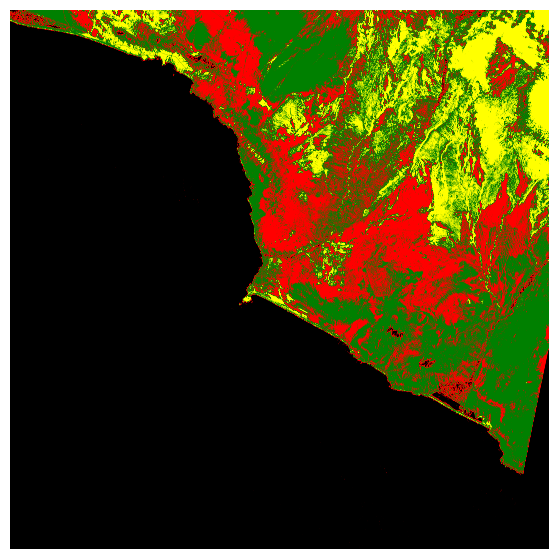

In [14]:
from matplotlib.colors import LinearSegmentedColormap

# Create a custom color map to represent our different 4 classes
cmap = LinearSegmentedColormap.from_list("", ["black","red","green","yellow"])
# Show the resulting array and save it as jpg image
plt.figure(figsize=[7,7])
plt.imshow(img_cl, cmap=cmap)
plt.axis('off')
plt.savefig("elhas_clustered.jpg", bbox_inches='tight')
plt.show()

In [15]:
# open the raster image
elmanagel = rio.open(data_path + "/T19KBA_20210320T145729_TCI_10m.jp2")

# create an empty array with same dimensions and data type 
elman_xyb = np.empty((elmanagel.height, elmanagel.width,elmanagel.count), elmanagel.meta['dtype'])
# loop through the raster bands and fill the empty array in x-y-bands order
for band in range(elman_xyb.shape[2]):
    elman_xyb[:,:,band] = elmanagel.read(band+1)
# convert to 1d array
elman_1d = elman_xyb[:,:,:3].reshape(elman_xyb.shape[0]*elman_xyb.shape[1], elman_xyb.shape[2])
# predict the clusters in the image 
pred = cl.predict(elman_1d)
# reshape the 1d array predictions to x-y-bands shape order (only one band)
elman_cul = pred
elman_cul = elman_cul.reshape(elman_xyb[:,:,0].shape)

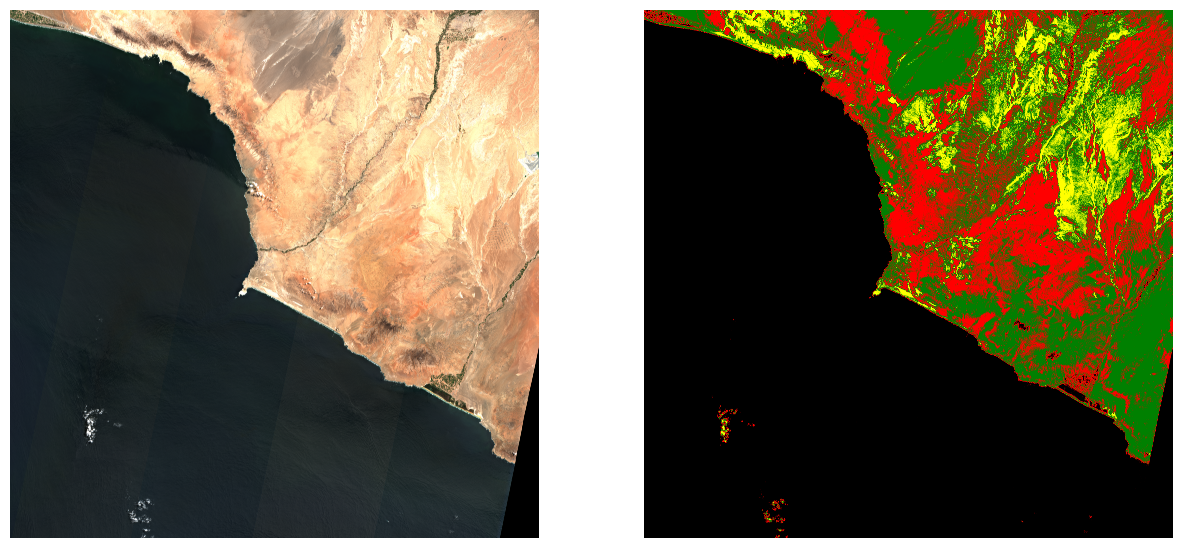

In [16]:
elman_arr = elmanagel.read() # Read the image
vmin, vmax = np.nanpercentile(elman_arr, (5,95)) # 5–95% contrast stretch
# show the original and predicted image
fig, (ax1,ax2) = plt.subplots(figsize=[15,15], nrows=1,ncols=2, sharey=False,)
show(elmanagel, cmap='gray', vmin=vmin, vmax=vmax, ax=ax1)
show(elman_cul, cmap=cmap, ax=ax2)
ax1.set_axis_off()
ax2.set_axis_off()
fig.savefig("pred.png", bbox_inches='tight')
plt.show()